Rejected Block/struct method, bs= 16x16, v=0
Rejected Block/struct method, bs= 64x32, v=0
Rejected Full block method, bs= 32x32, v=0
Rejected misc
Rejected new method, attention pruned with rows
Rejected small_epoch
Rejected Block/struct method, bs= 16x16, v=0
Rejected Block/struct method, bs= 64x32, v=0
Rejected Full block method, bs= 32x32, v=0
Rejected misc
Rejected new method, attention pruned with rows
Rejected small_epoch


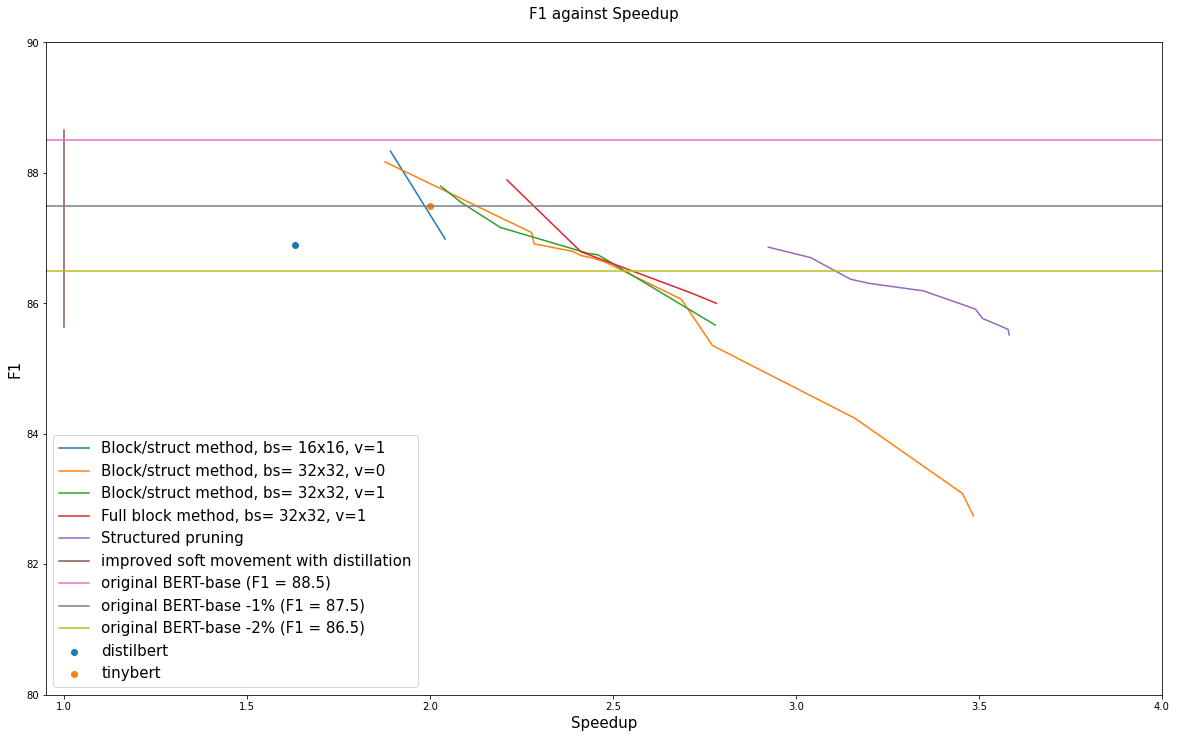

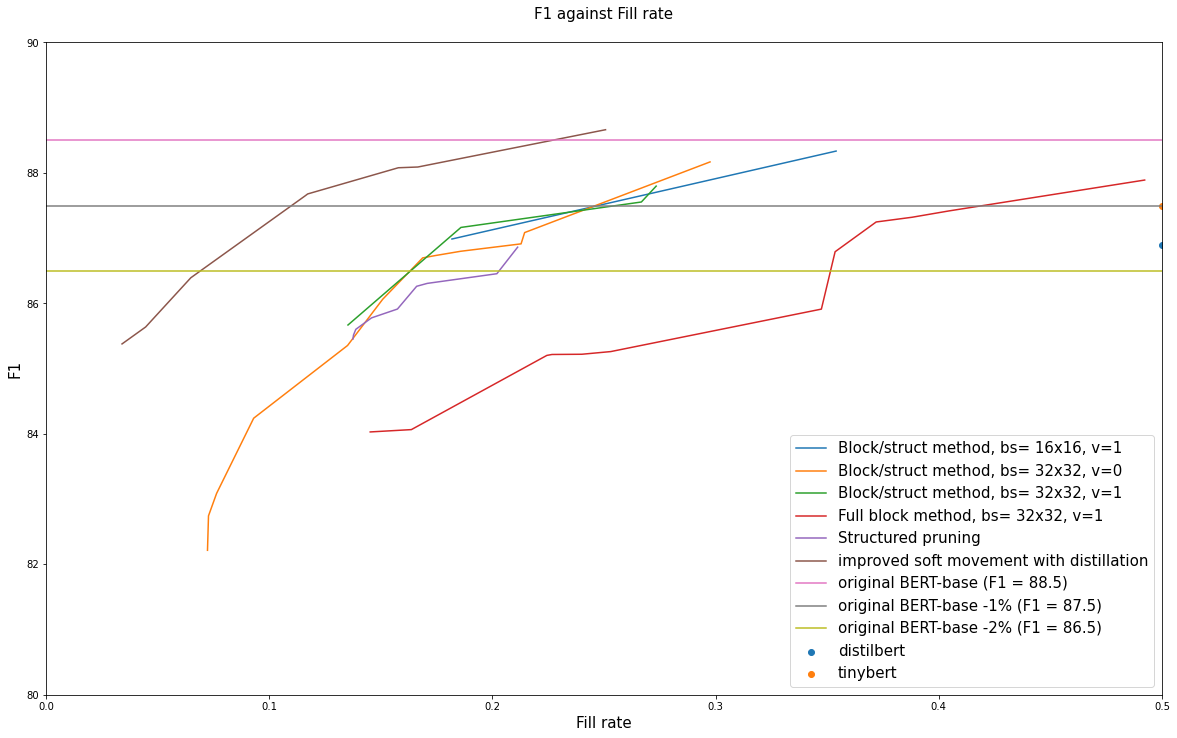

In [8]:
import pandas
import math
import numpy
from matplotlib import pyplot as pyplot
import os
import json
from pathlib import Path

#%matplotlib widget

class Plotter():
    def __init__(self, filename):
        self.filename = filename
        
    def read_checkpoint_info(self):
        j = json.load(open(self.filename))

        base_time = j["base_speed_report"]["eval_elapsed_time"]

        points = []
        max_speedup = 1.0
        for name, checkpoint in j["checkpoints"].items():
            
            try:
                #print(name, list(checkpoint.keys()))
                speedup = base_time / checkpoint["speed"]["eval_elapsed_time"]
                speedup = max(1.0, speedup)
            except:
                speedup = 1.0
            max_speedup=max(max_speedup, speedup)
            p = Path(name)
            eval_metrics = checkpoint.get("opt_eval_metrics")
            if eval_metrics is None or True:
                eval_metrics = json.load(open(p / "eval_metrics.json"))
            
            sparsity_report = json.load(open(p / "sparsity_report.json"))
            sparsity = 1.0 - (sparsity_report["linear_nnz"] / sparsity_report["linear_total"])
            sparse_args = json.load(open(p / "sparse_args.json"))
            
            
            point = dict(speedup=speedup, **eval_metrics, sparsity=sparsity, sparse_args=sparse_args, path=name)
            points.append(point)            
            
            
        return points

    def model_part_size(self, model_name, white_list, black_list):
        from transformers import AutoModelForQuestionAnswering
        from pytorch_block_sparse import BlockSparseModelPatcher

        model = AutoModelForQuestionAnswering.from_pretrained(model_name)

        a = {k:v for k,v in model.named_parameters()}
        total = 0
        for k,v in a.items():
            def check(x):            
                for bl in black_list:
                    if bl in x:
                        return False
                for wl in white_list:
                    if wl not in x:
                        return False
                return True
            if not check(k):
                continue

            total += v.numel()
        return total
    
    def distilbert_data(self):
        path = Path("distilbert_info.json")
        if path.exists():
            return json.load(path.open())
        total_distilbert = self.model_part_size("distilbert-base-uncased-distilled-squad",
                                                white_list=["weight"],
                                                black_list=["embeddings", "layer_norm", "qa"])
        
        total_bert = self.model_part_size("csarron/bert-base-uncased-squad-v1",
                                          white_list=["weight"],
                                          black_list=["embeddings", "LayerNorm", "qa"])
                    
        # From https://arxiv.org/pdf/1910.01108.pdf
        d = [{"f1":86.9, "exact": 79.1, "fill_rate": total_distilbert / total_bert, "speedup": 1.63, "annotate":"DistilBERT"}]
        
        json.dump(d, path.open("w"))
        
        return d
    
    def are16headsbetter(self):        
        """. We find that pruning half of the model’s
heads speeds up inference by up to ≈ 17.5% for higher batch sizes (this difference vanishes for
smaller batch sizes)."""
        pass
        
    def bert_tiny(self):
        "https://huggingface.co/mrm8488/bert-tiny-wrslb-finetuned-squadv1"
        
        
    def tinybert_data(self):
        "https://arxiv.org/pdf/1909.10351.pdf"
        """System SQuAD 1.1 SQuAD 2.0
EM F1 EM F1
BERTBASE (Teacher) 80.7 88.4 74.5 77.7
4-layer student models
BERT4-PKD 70.1 79.5 60.8 64.6
DistilBERT4 71.8 81.2 60.6 64.1
MiniLM4 - - - 69.7
TinyBERT4 72.7 82.1 68.2 71.8
6-layer student models
BERT6-PKD 77.1 85.3 66.3 69.8
DistilBERT6 78.1 86.2 66.0 69.5
MiniLM6 - - - 76.4
TinyBERT6 79.7 87.5 74.7 77.7"""
        
        """ Compared with the teacher
BERTBASE, TinyBERT4 is 7.5x smaller and 9.4x
faster in the model efficiency, while maintaining
competitive performances."""
        "TinyBERT6 2.0x BERT"        
        """System #Params #FLOPs Speedup MNLI-(m/mm) QQP QNLI SST-2 CoLA STS-B MRPC RTE Avg
BERTBASE (Teacher) 109M 22.5B 1.0x 83.9/83.4 71.1 90.9 93.4 52.8 85.2 87.5 67.0 79.5
BERTTINY 14.5M 1.2B 9.4x 75.4/74.9 66.5 84.8 87.6 19.5 77.1 83.2 62.6 70.2
BERTSMALL 29.2M 3.4B 5.7x 77.6/77.0 68.1 86.4 89.7 27.8 77.0 83.4 61.8 72.1
BERT4-PKD 52.2M 7.6B 3.0x 79.9/79.3 70.2 85.1 89.4 24.8 79.8 82.6 62.3 72.6
DistilBERT4 52.2M 7.6B 3.0x 78.9/78.0 68.5 85.2 91.4 32.8 76.1 82.4 54.1 71.9
MobileBERTTINY† 15.1M 3.1B - 81.5/81.6 68.9 89.5 91.7 46.7 80.1 87.9 65.1 77.0
TinyBERT4 (ours) 14.5M 1.2B 9.4x 82.5/81.8 71.3 87.7 92.6 44.1 80.4 86.4 66.6 77.0
BERT6-PKD 67.0M 11.3B 2.0x 81.5/81.0 70.7 89.0 92.0 - - 85.0 65.5 -
PD 67.0M 11.3B 2.0x 82.8/82.2 70.4 88.9 91.8 - - 86.8 65.3 -
DistilBERT6 67.0M 11.3B 2.0x 82.6/81.3 70.1 88.9 92.5 49.0 81.3 86.9 58.4 76.8
TinyBERT6 (ours) 67.0M 11.3B 2.0x 84.6/83.2 71.6 90.4 93.1 51.1 83.7 87.3 70.0 79.4"""
        
        # From https://arxiv.org/pdf/1910.01108.pdf
        d = [{"f1":87.5, "exact": 79.7, "fill_rate": 0.5, "speedup": 2.0, "annotate":"TinyBERT6"}]
        #d += [{"f1":82.1, "exact": 72.7, "fill_rate": 0.5, "speedup": 9.4, "annotate":"TinyBERT4"}]
        
        return d
       

        
    def mobilebert(self):
        "MobileBERTTINY"
        
        
    
    def read_reference_entries(self):
        defaults = dict(size=1, inner_sparsity=1, cols=1, rows=1, epochs=10)
        ret = dict(local_movement_pruning=[], soft_movement_with_distillation=[])
    
        xcel_file_name = "/home/lagunas/devel/hf/block_movement_pruning/notebooks/mvmt_pruning.xlsx"
        xcel = pandas.read_excel(xcel_file_name, index_col=0, sheet_name="Details - SQuAD")  
        xcel = pandas.DataFrame(xcel)
        for i, (r, d) in enumerate(xcel.iterrows()):
            if i > 2:
                if str(d[2]) != "nan":
                    name = d[2]
                    name_parts = name.split("_")
                    if name.startswith("topK_1.0"):
                        key = "local_movement_pruning"
                    elif name.startswith("l1_with_distil"):
                        key = "soft_movement_with_distillation"
                    else:
                        key = None
                    if key != None:
                        d = dict(name=name, fill_rate= d[3] / 100.0, exact=d[4], f1=d[5])

                        d.update(defaults)
                        ret[key].append(d)
                        
        
        # Add other networks
        ret["distilbert"] = self.distilbert_data()
        ret["tinybert"] = self.tinybert_data()
        
        return ret

    def check(self, d, equals, not_equals):
        for k,v in equals.items():
            if d[k] != v:
                #print(f"d[{k}]={d[k]} !={v}")
                return False
        for k,v in not_equals.items():
            if d[k] == v:
                return False
        return True
            
    def is_new_xp(self, xp):
        compare = dict(attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
#                       final_warmup=10,
                       regularization="l1")
                
        compare_different=dict(attention_block_cols = 1,
                               attention_block_rows = 1,                       
                               distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            cols = sparse_args['attention_block_cols']
            rows = sparse_args['attention_block_rows']
            #if cols == 768:
            #    return None
            if cols == 768:
                ret = "Structured pruning"
            else:
                ver = (1 - int(sparse_args.get("attention_output_with_dense", True)))
                ret = f"Block/struct method, bs= {rows}x{cols}, v={ver}"
            annotate = f"l="+ str(sparse_args['regularization_final_lambda'])
            annotate += f", fw=" + str(sparse_args['final_warmup'])
            annotate += ", al=(" + str(sparse_args.get('attention_lambda', "1.0")) + "," + str(sparse_args.get('dense_lambda', "1.0")) + ")"
            #annotate += ", ver=" + str(0 if sparse_args.get('attention_output_with_dense', True) else 1)
            return ret, annotate
        else:
            return None, None
    
    def is_full_block(self, xp):
        compare = dict(attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 32,
                       dense_block_rows = 32,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,
#                       final_warmup=10,
                       regularization="l1")
                
        compare_different=dict(attention_block_cols = 1,
                               attention_block_rows = 1,                       
                               distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            cols = sparse_args['attention_block_cols']
            rows = sparse_args['attention_block_rows']
            ver = (1 - int(sparse_args.get("attention_output_with_dense", True)))
            ret = f"Full block method, bs= {rows}x{cols}, v={ver}"
            annotate = f"l="+ str(sparse_args['regularization_final_lambda'])
            annotate += f", fw=" + str(sparse_args['final_warmup'])
            annotate += ", al=(" + str(sparse_args.get('attention_lambda', "1.0")) + "," + str(sparse_args.get('dense_lambda', "1.0")) + ")"
            #annotate += ", ver=" + str(0 if sparse_args.get('attention_output_with_dense', True) else 1)
            return ret, annotate
        else:
            return None, None
    
    def is_improved_mvmt_pruning(self, xp):
        compare = dict(attention_block_cols = 1,
                       attention_block_rows = 1,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,    
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)
        
        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "improved soft movement with distillation"
        else:
            return None

    
    def is_longer_final_warmup(self, xp):
        compare = dict(attention_block_cols = 32,
                       attention_block_rows = 32,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=15,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "new method, longer final warmup (15 instead of 10)"
        else:
            return None
        
    def is_attention_rows(self, xp):
        compare = dict(attention_block_cols = 768,
                       attention_block_rows = 1,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "new method, attention pruned with rows"
        else:
            return None
        
    def is_block_sparse(self, xp):
        compare = dict(attention_block_cols = 32,
                       attention_block_rows = 32,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 32,
                       dense_block_rows = 32,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "block_sparse"
        else:
            return None
                                                                                
    
    def categorize(self, xp):
        checkpoint_index = int(xp["path"].split("/")[-1].split("-")[-1])
        if checkpoint_index <= 75000:
            return "small_epoch", ""        
    
        full_block, annotate = self.is_full_block(xp)
        if full_block:
            return full_block, annotate

    
        new_xp, annotate = self.is_new_xp(xp)
        if new_xp:
            return new_xp, annotate
            
        annotate = ""
        improved_mvmt_pruning = self.is_improved_mvmt_pruning(xp)
        if improved_mvmt_pruning:
            return improved_mvmt_pruning, annotate            
        
        longer_warmup = self.is_longer_final_warmup(xp)
        if longer_warmup:
            return longer_warmup, annotate
        
        attention_rows = self.is_attention_rows(xp)
        if attention_rows:
            return attention_rows, annotate  
        
        block_sparse = self.is_block_sparse(xp)
        if block_sparse:
            return block_sparse, annotate
        
        return "misc", annotate
    
    def process_checkpoint(self, checkpoint):
        d = checkpoint
        ret = dict(fill_rate=1.0 - d["sparsity"], f1=d["f1"])
        
        speedup = d["speedup"]
        if speedup > 1:
            ret["speedup"] = speedup
        return ret
    
    def checkpoints_prepare(self, checkpoints, print_misc):
        ret = {}
        for checkpoint in checkpoints:
            cat, annotate = self.categorize(checkpoint)
            if cat == None:
                continue
            if cat not in ret:
                ret[cat] = []
            processed = self.process_checkpoint(checkpoint)
            processed["annotate"] = annotate
            processed["path"] = checkpoint["path"]
            if cat == "misc" and print_misc:
                print(json.dumps(checkpoint["sparse_args"], indent=4))
            ret[cat].append(processed)
        return ret
    
    def filter_checkpoints(self, checkpoints, key="speedup"):
        if key == "fill_rate":
            sgn = -1
        else:
            sgn = 1
        sort_by_key = lambda x : sgn * x.get(key, 1.0)
        checkpoints.sort(key = sort_by_key, reverse = True)
        best_c = checkpoints[0]
        
        filtered_checkpoints = [best_c]
        for checkpoint in checkpoints[1:]:
            if checkpoint["f1"] > filtered_checkpoints[-1]["f1"]:
                filtered_checkpoints.append(checkpoint)
        
        
        filtered_checkpoints.sort(key=sort_by_key, reverse = False)
        
        return filtered_checkpoints
    
   
                        
    def plot(self, key):        
        print_misc = False
        draw_labels = False
        convex_envelop = True
        only_dots = False or not convex_envelop

        fontsize = 15

        checkpoints = self.read_checkpoint_info()

        reference_entries = self.read_reference_entries()
        
        labels = []
        parts = []
        reference_black_list = ["local_movement_pruning", "soft_movement_with_distillation"]
        for k,v in reference_entries.items():
            if k in reference_black_list:                
                continue
            labels.append(k)
            parts.append(v)
        
        checkpoints_plot_info = self.checkpoints_prepare(checkpoints, print_misc = print_misc)
                
        category_keys = list(checkpoints_plot_info.keys())
        category_keys.sort()


        if key == "speedup":
            legend_loc = 'lower left'
            x_min = 0.95
            x_max = 4.0
        else:
            legend_loc = 'lower right'
            x_min = 0.0
            x_max = 0.5
            
        y_min = 80
        y_max = 90
  

        
    #    select = ['block_sparse', 'improved soft movement with distillation', 'misc', 'new method, attention pruned with rows', 'new method, longer final warmup (15 instead of 10)', 'new xp, block_size= 16x16', 'new xp, block_size= 32x32', 'new xp, block_size= 64x32', 'small_epoch']
        black_list = ["small_epoch", 'new method, attention pruned with rows']
        white_list = ['improved soft movement with distillation',
                      "Structured pruning",
                      "Block/struct method, bs= 32x32, v=0",
                      "Block/struct method, bs= 32x32, v=1",
                      "Block/struct method, bs= 16x16, v=1",
                      "Full block method, bs= 32x32, v=1",
                      'new xp, block_size= 64x768'] #, 'new xp, block_size= 16x16']
        #white_list = None
        
        for k in category_keys:
            if white_list is not None and k not in white_list:
                print(f"Rejected {k}")
                continue
            if k in black_list:         
                continue
            v = checkpoints_plot_info[k]
            labels.append(k)
            parts.append(v)
        
        
        markers = ["o", "v", "s", "+", "v"]

        fig = pyplot.figure(figsize=(20,12))
        ax1 = fig.add_subplot(111)
        max_x = 0


        
        for i, data in enumerate(parts):
            label = labels[i]
            if convex_envelop:
                data = self.filter_checkpoints(data, key = key)
                        
            x = [e.get(key, 1.0) for e in data]
            max_x = max(max_x, max(x))
            y = [e["f1"] for e in data]
        
            if len(x) == 1 or only_dots:
                pyplot.scatter(x, y, cmap='viridis', alpha=1.0, label = label) #, marker=markers[i]) # cool
            else:
                pyplot.plot(x, y, label = labels[i]) #, marker=markers[i]) # cool
            
            if draw_labels:
                try:
                    for i, txt in enumerate(x):
                        if x_min is None or x[i] >= x_min and x[i] <= x_max:
                            if y_min is None or y[i] >= y_min and y[i] <= y_max:
                                ax1.annotate(data[i].get("annotate", ""), (x[i]+0.005, y[i]+0.005))
                except Exception as e:
                    print(e)
                    pass
            
        for i in range(3):
            f1 = 88.5 - i
            pyplot.plot([0,10], [88.5 - i] * 2, label=f"original BERT-base {'' if i == 0 else str(-i)+'% '}(F1 = {f1})")
        
        
        pyplot.legend(loc=legend_loc, prop={'size': fontsize})
        #pyplot.xscale('log')
        
        if x_min != None:
            pyplot.xlim(x_min, x_max)
        if y_min != None:
            pyplot.ylim(y_min, y_max)
        XLabel = key.replace("_", " ").capitalize()
        pyplot.xlabel(XLabel, fontsize=fontsize)
        YLabel = "F1"
        pyplot.ylabel(YLabel, fontsize=fontsize)
        title = '%s against %s\n' % (YLabel, XLabel)
        pyplot.title(title, fontsize=fontsize)
        
       
        
p = Plotter("results5.json")
p.plot("speedup")
p.plot("fill_rate")




In [14]:
import json

a = json.load(open("results15.json"))

for k,v in a["checkpoints"].items():
    r = v["speed"]["cuda_eval_elapsed_time"] / a["base_speed_report"]["cuda_eval_elapsed_time"] 
    print(1.0 / r, v["opt_eval_metrics"]["f1"])
    
    


2.164940846792677 87.07610213911921
2.245216930504649 86.62745564109652
2.4645488432724982 86.85787750084084
2.5050884086172367 86.64151988736798
2.255967592742072 86.84346997900737
2.5084184050666347 86.63235572290178
2.5252660322345606 86.71968503618079
2.5772151856660086 86.58426699451658
2.0001936883579 87.56439208763325
1.3984045936775356 85.66626983371626
3.2084716047888633 85.6071153919288
1.1730445404670231 87.64967103979136
1.1682387023124063 87.59923644792065
1.2964750721534022 86.3547925481507
1.4110792065234719 88.08831525592305
1.4135786392443785 88.10463591853348
1.4138374267296698 87.95145431777735
2.2869413397518485 85.3167029862563
2.291635932799037 85.17930403802184
3.536028188622967 84.56290825102765
3.5674204636012683 84.26442986520863
2.720261889621394 86.06827252573265
2.103846020186399 87.70461789964966
2.117307736381609 87.48291010744668
0.9564597736183946 88.13888839423888
0.9709383100562968 86.2154189083501
1.5277053610355236 87.30139925832849
1.56469203625720

KeyError: 'cuda_eval_elapsed_time'